# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

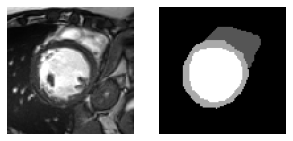

(96, 96)


In [4]:

import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [5]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       # self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [17]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [28]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(4,1,96,96))

RuntimeError: ignored

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [9]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    
    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


"\ndef dice_loss(pred,target, smooth = 1.):\n\n    pred = pred.contiguous()\n    target = target.contiguous()    \n    \n    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.\n\n    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().\n\n    \n\n    intersection = (pred * target).sum(dim=2).sum(dim=2)\n    \n    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))\n    \n    return loss.mean()\n\n\ncriterion = nn.CrossEntropyLoss()\n\n# so we have two types of loss the dice loss and cross entropy loss\n\ndef optimizer():\n  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)\n\noptimiz

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [14]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1/10: 4img [00:00, 15.04img/s]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 8img [00:00, 16.90img/s, loss (batch)=0.0676]

train loss 0.06759003549814224  step : 1  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.43948814272880554  step : 2  epoch : 0


Epoch 1/10: 12img [00:00, 18.64img/s, loss (batch)=0.152]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.15188363194465637  step : 3  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 20img [00:01, 22.00img/s, loss (batch)=0.179]

train loss 0.3283597528934479  step : 4  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.1788666695356369  step : 5  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 28img [00:01, 24.25img/s, loss (batch)=0.157]

train loss 0.1485617458820343  step : 6  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.15704849362373352  step : 7  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 36img [00:01, 25.50img/s, loss (batch)=0.182]

train loss 0.14166422188282013  step : 8  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.18161657452583313  step : 9  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 44img [00:01, 25.65img/s, loss (batch)=0.139]

train loss 0.1342903971672058  step : 10  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.13911454379558563  step : 11  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 52img [00:02, 25.94img/s, loss (batch)=0.0886]

train loss 0.1109025776386261  step : 12  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.088555246591568  step : 13  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 60img [00:02, 25.99img/s, loss (batch)=0.119]

train loss 0.10896214842796326  step : 14  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.11904209107160568  step : 15  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 68img [00:02, 26.17img/s, loss (batch)=0.156] 

train loss 0.07333573698997498  step : 16  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.1562606245279312  step : 17  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 76img [00:03, 26.63img/s, loss (batch)=0.0954]

train loss 0.10162746906280518  step : 18  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09538331627845764  step : 19  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 84img [00:03, 26.84img/s, loss (batch)=0.141]

train loss 0.15174725651741028  step : 20  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.1410871148109436  step : 21  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 92img [00:03, 26.72img/s, loss (batch)=0.131] 

train loss 0.09723469614982605  step : 22  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.13102450966835022  step : 23  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 1/10: 100img [00:04, 26.67img/s, loss (batch)=0.096]

train loss 0.1351575255393982  step : 24  epoch : 0
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09602919965982437  step : 25  epoch : 0


Epoch 1/10: 100img [00:04, 23.90img/s, loss (batch)=0.096]
Epoch 2/10: 4img [00:00, 15.85img/s, loss (batch)=0.0987]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09870801866054535  step : 26  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 12img [00:00, 22.56img/s, loss (batch)=0.105] 

train loss 0.09677895903587341  step : 27  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.10500766336917877  step : 28  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 20img [00:00, 24.30img/s, loss (batch)=0.116]

train loss 0.11351922154426575  step : 29  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.11617403477430344  step : 30  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 28img [00:01, 25.79img/s, loss (batch)=0.0758]

train loss 0.09810725599527359  step : 31  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07576146721839905  step : 32  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 36img [00:01, 26.30img/s, loss (batch)=0.0816]

train loss 0.10535763204097748  step : 33  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08156026899814606  step : 34  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 44img [00:01, 26.31img/s, loss (batch)=0.0955]

train loss 0.14129267632961273  step : 35  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09550584852695465  step : 36  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 52img [00:02, 26.89img/s, loss (batch)=0.0628]

train loss 0.09407839179039001  step : 37  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06275457888841629  step : 38  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 60img [00:02, 26.90img/s, loss (batch)=0.0698]

train loss 0.07664735615253448  step : 39  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06979476660490036  step : 40  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 68img [00:02, 26.45img/s, loss (batch)=0.0816]

train loss 0.11329653859138489  step : 41  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08158668130636215  step : 42  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 76img [00:03, 26.83img/s, loss (batch)=0.0978]

train loss 0.08323902636766434  step : 43  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09778907895088196  step : 44  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 84img [00:03, 26.73img/s, loss (batch)=0.085] 

train loss 0.06219731271266937  step : 45  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08502581715583801  step : 46  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 92img [00:03, 26.73img/s, loss (batch)=0.0836]

train loss 0.1087133064866066  step : 47  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08355396240949631  step : 48  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 2/10: 100img [00:03, 26.91img/s, loss (batch)=0.0837]

train loss 0.08234312385320663  step : 49  epoch : 1
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08366251736879349  step : 50  epoch : 1


Epoch 2/10: 100img [00:04, 24.82img/s, loss (batch)=0.0837]
Epoch 3/10: 4img [00:00, 16.13img/s, loss (batch)=0.132]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.13190913200378418  step : 51  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 12img [00:00, 23.16img/s, loss (batch)=0.0597]

train loss 0.05877355858683586  step : 52  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05968533456325531  step : 53  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 20img [00:00, 25.38img/s, loss (batch)=0.077] 

train loss 0.06670563668012619  step : 54  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07700145244598389  step : 55  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 28img [00:01, 25.85img/s, loss (batch)=0.0803]

train loss 0.11327062547206879  step : 56  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08029874414205551  step : 57  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 36img [00:01, 26.05img/s, loss (batch)=0.0686]

train loss 0.13438184559345245  step : 58  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0686199814081192  step : 59  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 44img [00:01, 26.48img/s, loss (batch)=0.111] 

train loss 0.08988498896360397  step : 60  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.11125878244638443  step : 61  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 52img [00:02, 26.44img/s, loss (batch)=0.0852]

train loss 0.07559189200401306  step : 62  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08523516356945038  step : 63  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 60img [00:02, 26.45img/s, loss (batch)=0.106] 

train loss 0.09367989003658295  step : 64  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.10624383389949799  step : 65  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 68img [00:02, 26.13img/s, loss (batch)=0.0893]

train loss 0.09066936373710632  step : 66  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0892535150051117  step : 67  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 76img [00:03, 26.60img/s, loss (batch)=0.0683]

train loss 0.07996397465467453  step : 68  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06831436604261398  step : 69  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 84img [00:03, 26.87img/s, loss (batch)=0.0758]

train loss 0.06844387948513031  step : 70  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.075815349817276  step : 71  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 92img [00:03, 26.97img/s, loss (batch)=0.0589]

train loss 0.07740256935358047  step : 72  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05892013758420944  step : 73  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 3/10: 100img [00:03, 27.01img/s, loss (batch)=0.0592]

train loss 0.06933997571468353  step : 74  epoch : 2
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.059150371700525284  step : 75  epoch : 2


Epoch 3/10: 100img [00:04, 24.84img/s, loss (batch)=0.0592]
Epoch 4/10: 4img [00:00, 16.95img/s, loss (batch)=0.0903]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09029531478881836  step : 76  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 12img [00:00, 23.10img/s, loss (batch)=0.11] 

train loss 0.148514986038208  step : 77  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.10967622697353363  step : 78  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 20img [00:00, 25.41img/s, loss (batch)=0.082] 

train loss 0.07374811917543411  step : 79  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08202138543128967  step : 80  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 28img [00:01, 26.19img/s, loss (batch)=0.0793]

train loss 0.06613226979970932  step : 81  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07928827404975891  step : 82  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 36img [00:01, 26.48img/s, loss (batch)=0.0689]

train loss 0.08264176547527313  step : 83  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06892308592796326  step : 84  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 44img [00:01, 26.13img/s, loss (batch)=0.123] 

train loss 0.06630998104810715  step : 85  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.12286283075809479  step : 86  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 52img [00:02, 26.26img/s, loss (batch)=0.0811]

train loss 0.08916819840669632  step : 87  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08113116770982742  step : 88  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 60img [00:02, 26.31img/s, loss (batch)=0.0679]

train loss 0.06922582536935806  step : 89  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06785699725151062  step : 90  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 68img [00:02, 26.34img/s, loss (batch)=0.102] 

train loss 0.09677108377218246  step : 91  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.1016371101140976  step : 92  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 76img [00:03, 26.64img/s, loss (batch)=0.0854]

train loss 0.06905172765254974  step : 93  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0854116827249527  step : 94  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 84img [00:03, 26.47img/s, loss (batch)=0.0751]

train loss 0.07753929495811462  step : 95  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07506172358989716  step : 96  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 92img [00:03, 26.74img/s, loss (batch)=0.0667]

train loss 0.12201806902885437  step : 97  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06668315082788467  step : 98  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 4/10: 100img [00:03, 26.62img/s, loss (batch)=0.0838]

train loss 0.07707302272319794  step : 99  epoch : 3
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08379998058080673  step : 100  epoch : 3


Epoch 4/10: 100img [00:04, 24.81img/s, loss (batch)=0.0838]
Epoch 5/10: 4img [00:00, 15.88img/s, loss (batch)=0.088]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08804628252983093  step : 101  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 12img [00:00, 23.18img/s, loss (batch)=0.0802]

train loss 0.07714536786079407  step : 102  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08019626140594482  step : 103  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 20img [00:00, 24.60img/s, loss (batch)=0.0786]

train loss 0.06949016451835632  step : 104  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07859044522047043  step : 105  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 28img [00:01, 25.46img/s, loss (batch)=0.0655]

train loss 0.0689602792263031  step : 106  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06554031372070312  step : 107  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 36img [00:01, 25.88img/s, loss (batch)=0.0876]

train loss 0.07006002962589264  step : 108  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08762408792972565  step : 109  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 44img [00:01, 25.73img/s, loss (batch)=0.118] 

train loss 0.06084581837058067  step : 110  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.11845818907022476  step : 111  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 52img [00:02, 25.62img/s, loss (batch)=0.0653]

train loss 0.05344685539603233  step : 112  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06533639132976532  step : 113  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 60img [00:02, 25.78img/s, loss (batch)=0.0659]

train loss 0.0830952376127243  step : 114  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0659191906452179  step : 115  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 68img [00:02, 26.33img/s, loss (batch)=0.0652]

train loss 0.07666058093309402  step : 116  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06523299962282181  step : 117  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 76img [00:03, 26.52img/s, loss (batch)=0.0679]

train loss 0.09379735589027405  step : 118  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0679173618555069  step : 119  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 84img [00:03, 26.50img/s, loss (batch)=0.056] 

train loss 0.06263569742441177  step : 120  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05595225840806961  step : 121  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 92img [00:03, 26.64img/s, loss (batch)=0.0713]

train loss 0.0579291395843029  step : 122  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.071322500705719  step : 123  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 5/10: 100img [00:03, 26.67img/s, loss (batch)=0.0776]

train loss 0.0552760511636734  step : 124  epoch : 4
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07755161821842194  step : 125  epoch : 4


Epoch 5/10: 100img [00:04, 24.54img/s, loss (batch)=0.0776]
Epoch 6/10: 4img [00:00, 16.39img/s, loss (batch)=0.0668]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06678318977355957  step : 126  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 12img [00:00, 22.73img/s, loss (batch)=0.0706]

train loss 0.05905194580554962  step : 127  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07060032337903976  step : 128  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 20img [00:00, 25.16img/s, loss (batch)=0.0558]

train loss 0.06547711044549942  step : 129  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05583786964416504  step : 130  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 28img [00:01, 25.87img/s, loss (batch)=0.0626]

train loss 0.06756146252155304  step : 131  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06260368973016739  step : 132  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 36img [00:01, 26.27img/s, loss (batch)=0.0607]

train loss 0.06227828562259674  step : 133  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.060726504772901535  step : 134  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 44img [00:01, 26.39img/s, loss (batch)=0.0589]

train loss 0.06212540343403816  step : 135  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05888644978404045  step : 136  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 52img [00:02, 26.10img/s, loss (batch)=0.0658]

train loss 0.07299033552408218  step : 137  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06576956808567047  step : 138  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 60img [00:02, 25.97img/s, loss (batch)=0.0609]

train loss 0.05415276065468788  step : 139  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.060888662934303284  step : 140  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 68img [00:02, 25.61img/s, loss (batch)=0.0561]

train loss 0.04436759650707245  step : 141  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05610741674900055  step : 142  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 76img [00:03, 26.35img/s, loss (batch)=0.0388]

train loss 0.05127738043665886  step : 143  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.03877226635813713  step : 144  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 84img [00:03, 26.38img/s, loss (batch)=0.0594]

train loss 0.060951411724090576  step : 145  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.059405963867902756  step : 146  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 92img [00:03, 26.62img/s, loss (batch)=0.0553]

train loss 0.062745600938797  step : 147  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.055330295115709305  step : 148  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 6/10: 100img [00:03, 26.68img/s, loss (batch)=0.0571]

train loss 0.052965737879276276  step : 149  epoch : 5
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05706046521663666  step : 150  epoch : 5


Epoch 6/10: 100img [00:04, 24.59img/s, loss (batch)=0.0571]
Epoch 7/10: 4img [00:00, 16.02img/s, loss (batch)=0.0674]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06735151261091232  step : 151  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 12img [00:00, 23.67img/s, loss (batch)=0.0499]

train loss 0.051819708198308945  step : 152  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.049873966723680496  step : 153  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 20img [00:00, 25.35img/s, loss (batch)=0.0577]

train loss 0.0671299397945404  step : 154  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.057700157165527344  step : 155  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 28img [00:01, 25.49img/s, loss (batch)=0.0647]

train loss 0.05603500083088875  step : 156  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06474678218364716  step : 157  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 36img [00:01, 25.74img/s, loss (batch)=0.0471]

train loss 0.0747523233294487  step : 158  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.04710578918457031  step : 159  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 44img [00:01, 25.63img/s, loss (batch)=0.0417]

train loss 0.056035060435533524  step : 160  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.04166078194975853  step : 161  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 52img [00:02, 25.76img/s, loss (batch)=0.0543]

train loss 0.05484955012798309  step : 162  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05431683734059334  step : 163  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 60img [00:02, 26.03img/s, loss (batch)=0.0425]

train loss 0.04940912872552872  step : 164  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.042524807155132294  step : 165  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 68img [00:02, 26.17img/s, loss (batch)=0.0443]

train loss 0.05440276488661766  step : 166  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.04429487884044647  step : 167  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 76img [00:03, 26.58img/s, loss (batch)=0.0525]

train loss 0.06585604697465897  step : 168  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.052514806389808655  step : 169  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 84img [00:03, 26.65img/s, loss (batch)=0.0585]

train loss 0.04304071143269539  step : 170  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.058491069823503494  step : 171  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 92img [00:03, 26.75img/s, loss (batch)=0.0648]

train loss 0.05500892922282219  step : 172  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06476586312055588  step : 173  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 7/10: 100img [00:03, 26.86img/s, loss (batch)=0.0475]

train loss 0.04571310058236122  step : 174  epoch : 6
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.04747919738292694  step : 175  epoch : 6


Epoch 7/10: 100img [00:04, 24.66img/s, loss (batch)=0.0475]
Epoch 8/10: 4img [00:00, 17.49img/s, loss (batch)=0.0486]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.048626624047756195  step : 176  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 16img [00:00, 25.38img/s, loss (batch)=0.047]

train loss 0.041729629039764404  step : 177  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0469651073217392  step : 178  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 20img [00:00, 26.27img/s, loss (batch)=0.0544]

train loss 0.052727777510881424  step : 179  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.054385263472795486  step : 180  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 28img [00:01, 26.49img/s, loss (batch)=0.063] 

train loss 0.044620998203754425  step : 181  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06302367150783539  step : 182  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 36img [00:01, 25.91img/s, loss (batch)=0.0629]

train loss 0.04728701710700989  step : 183  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0629422515630722  step : 184  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 44img [00:01, 26.74img/s, loss (batch)=0.0723]

train loss 0.05338633805513382  step : 185  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07232736051082611  step : 186  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 52img [00:02, 26.30img/s, loss (batch)=0.056] 

train loss 0.05987751483917236  step : 187  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.056033194065093994  step : 188  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 60img [00:02, 26.15img/s, loss (batch)=0.0522]

train loss 0.052019305527210236  step : 189  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.052158936858177185  step : 190  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 68img [00:02, 25.92img/s, loss (batch)=0.0614]

train loss 0.04291839152574539  step : 191  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06139683723449707  step : 192  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 76img [00:03, 26.37img/s, loss (batch)=0.0593]

train loss 0.059861037880182266  step : 193  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05930984020233154  step : 194  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 84img [00:03, 26.83img/s, loss (batch)=0.0996]

train loss 0.05170958489179611  step : 195  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09955640137195587  step : 196  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 92img [00:03, 26.58img/s, loss (batch)=0.0622]

train loss 0.043679703027009964  step : 197  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.062218427658081055  step : 198  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 8/10: 100img [00:03, 26.49img/s, loss (batch)=0.0848]

train loss 0.06475004553794861  step : 199  epoch : 7
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.08479534834623337  step : 200  epoch : 7


Epoch 8/10: 100img [00:04, 24.84img/s, loss (batch)=0.0848]
Epoch 9/10: 4img [00:00, 15.37img/s, loss (batch)=0.0535]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.053509198129177094  step : 201  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 12img [00:00, 23.04img/s, loss (batch)=0.0433]

train loss 0.05466298758983612  step : 202  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0432756282389164  step : 203  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 20img [00:00, 24.29img/s, loss (batch)=0.0582]

train loss 0.05074060708284378  step : 204  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05818365514278412  step : 205  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 28img [00:01, 24.98img/s, loss (batch)=0.0652]

train loss 0.0782838687300682  step : 206  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06515757739543915  step : 207  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 36img [00:01, 25.72img/s, loss (batch)=0.0718]

train loss 0.04702005162835121  step : 208  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07181620597839355  step : 209  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 44img [00:01, 26.71img/s, loss (batch)=0.0563]

train loss 0.09505908936262131  step : 210  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05633554980158806  step : 211  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 52img [00:02, 26.36img/s, loss (batch)=0.0659]

train loss 0.0618070550262928  step : 212  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06587708741426468  step : 213  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 60img [00:02, 26.11img/s, loss (batch)=0.0924]

train loss 0.0771624743938446  step : 214  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.09238431602716446  step : 215  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 68img [00:02, 26.70img/s, loss (batch)=0.0594]

train loss 0.05415105074644089  step : 216  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.059371642768383026  step : 217  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 76img [00:03, 26.55img/s, loss (batch)=0.0649]

train loss 0.11827198415994644  step : 218  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06485389173030853  step : 219  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 84img [00:03, 26.54img/s, loss (batch)=0.0707]

train loss 0.05828206241130829  step : 220  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.07069306075572968  step : 221  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 92img [00:03, 26.48img/s, loss (batch)=0.0695]

train loss 0.05345115065574646  step : 222  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06948304176330566  step : 223  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 9/10: 100img [00:03, 26.58img/s, loss (batch)=0.0551]

train loss 0.057223930954933167  step : 224  epoch : 8
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.055083196610212326  step : 225  epoch : 8


Epoch 9/10: 100img [00:04, 24.55img/s, loss (batch)=0.0551]
Epoch 10/10: 4img [00:00, 15.73img/s, loss (batch)=0.0554]

mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.055444978177547455  step : 226  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 12img [00:00, 23.39img/s, loss (batch)=0.0509]

train loss 0.06302426010370255  step : 227  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05093301832675934  step : 228  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 20img [00:00, 24.76img/s, loss (batch)=0.0562]

train loss 0.061655495315790176  step : 229  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05620057135820389  step : 230  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 28img [00:01, 25.48img/s, loss (batch)=0.0557]

train loss 0.057170867919921875  step : 231  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.055697374045848846  step : 232  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 36img [00:01, 25.97img/s, loss (batch)=0.0556]

train loss 0.048296231776475906  step : 233  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05555244907736778  step : 234  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 44img [00:01, 26.43img/s, loss (batch)=0.0518]

train loss 0.06079619377851486  step : 235  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.0517517514526844  step : 236  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 52img [00:02, 26.18img/s, loss (batch)=0.0587]

train loss 0.06036458909511566  step : 237  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05874653533101082  step : 238  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 60img [00:02, 25.63img/s, loss (batch)=0.0541]

train loss 0.04531280696392059  step : 239  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05412273481488228  step : 240  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 68img [00:02, 25.59img/s, loss (batch)=0.05]  

train loss 0.046519409865140915  step : 241  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05003984272480011  step : 242  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 76img [00:03, 26.24img/s, loss (batch)=0.0671]

train loss 0.05258258804678917  step : 243  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06709408760070801  step : 244  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 84img [00:03, 26.35img/s, loss (batch)=0.0619]

train loss 0.04280700907111168  step : 245  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.06189362704753876  step : 246  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 92img [00:03, 26.29img/s, loss (batch)=0.0407]

train loss 0.04698747768998146  step : 247  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.04067837819457054  step : 248  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])


Epoch 10/10: 100img [00:04, 26.47img/s, loss (batch)=0.0581]

train loss 0.05489310622215271  step : 249  epoch : 9
mask size : torch.Size([4, 96, 96])

image size : torch.Size([4, 1, 96, 96])
train loss 0.05809186398983002  step : 250  epoch : 9


Epoch 10/10: 100img [00:04, 24.42img/s, loss (batch)=0.0581]


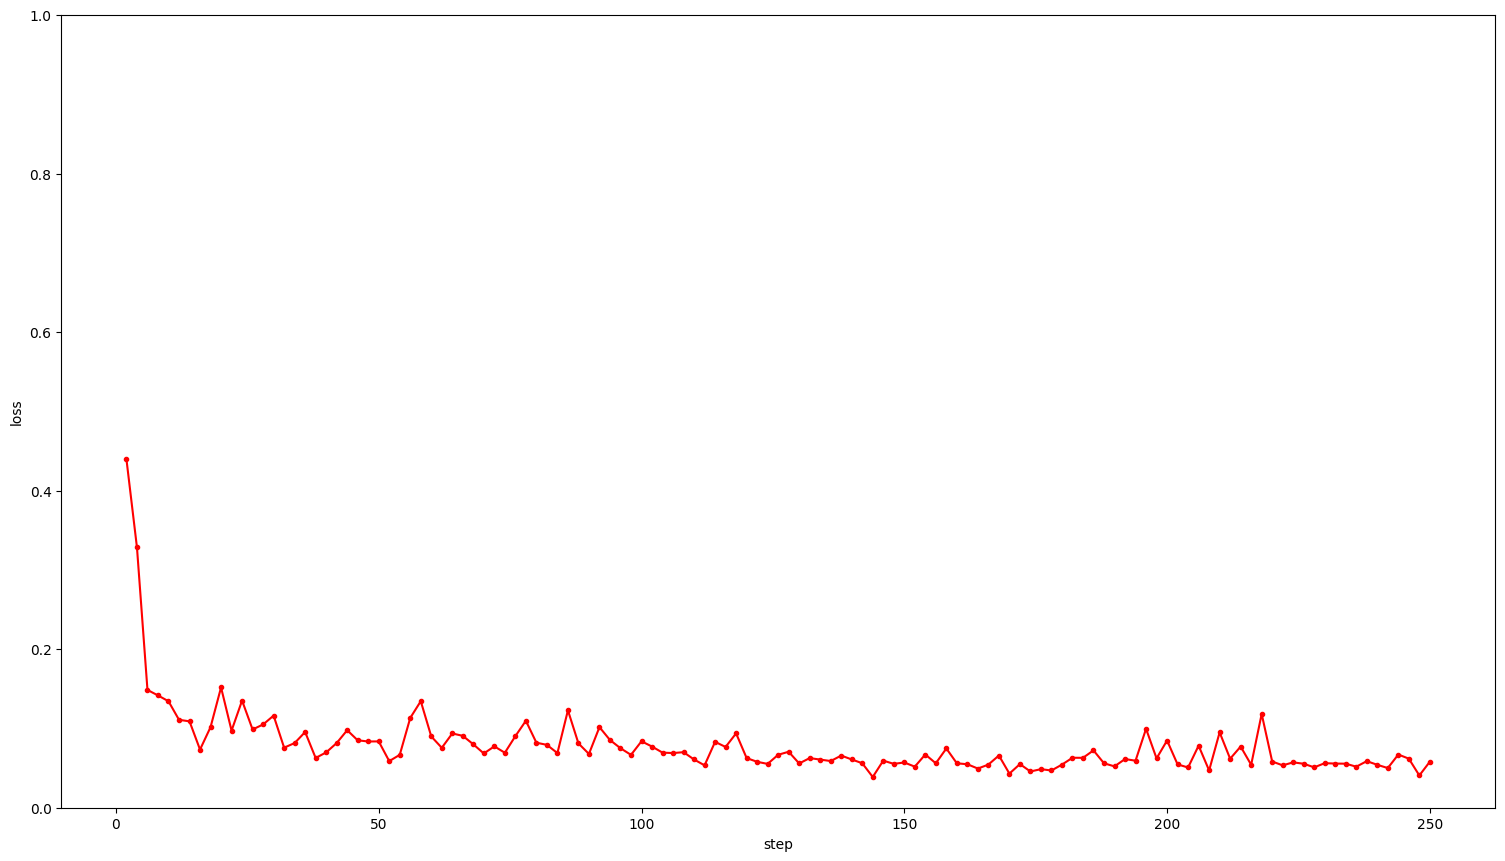

In [32]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
"""
def dice_coef_binary_4cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 4 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = torch.flatten(F.one_hot(torch.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = torch.flatten(y_pred[...,1:])
    intersect = F.sum(y_true_f * y_pred_f, axis=-1)
    denom = F.sum(y_true_f + y_pred_f, axis=-1)
    return F.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary_4cat(y_true, y_pred)

"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 4
batch_size = 4
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer_fn = optim.Adam(model.parameters(),lr = 0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
scheduler_fn = lr_scheduler.StepLR(optimizer_fn,step_size=30,gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
if isinstance(loss_fn,torch.nn.Module): ##just to be sure that criterion is on the correct device.
  loss_fn.to(device)

def train_net(model,
              device,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 0.00001,
              optimizer = optimizer_fn,
              scheduler = scheduler_fn,
              criterion = loss_fn,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 


  global_step = 0
  steps =[]
  losses=[]
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
  
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
      #for batch in training_data_loader:
          img, mask = sample

          #print('\nimage size :', img.shape)
          print('mask size :',mask.shape)
          img=img.unsqueeze(1)
          print('\nimage size :', img.shape)
          img  = img.to(device = device)
          #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          #print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          #print(out.shape)
          optimizer.zero_grad()
          cross_entropy_loss = criterion (out,mask) 
          #dice_loss = dice_coef_binary_loss(mask,out)
          dice= dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
          #loss = cross_entropy_loss + dice
          loss = cross_entropy_loss
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          

         # optimizer.zero_grad(set_to_none=True)
         # grad_scaler.scale(loss).backward()
         # grad_scaler.step(optimizer)
         # grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          losses.append(loss.item())
          steps.append(global_step)
          loss.backward()
          optimizer.step()
          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})
  plt.plot(steps[1::2],losses[1::2],'.r-')
  plt.xlabel("step")
  plt.ylabel("loss")
  x1,x2,y1,y2 = plt.axis()  
  plt.axis((x1,x2,0,1))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  fig.set_dpi(100)
  plt.show()
  return model
model = train_net(model,device,10,4 ,0.0001)
torch.save(model.state_dict(), checkpoint_path)

    

# Validation

In [34]:
import numpy as np
from torch.autograd import Variable
print(os.getcwd())

/content


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss score for image :  0.03914152830839157
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


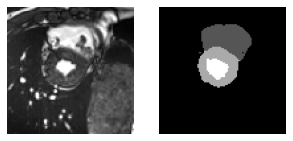

loss score for image :  0.05449143424630165
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


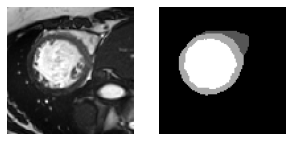

loss score for image :  0.051788538694381714
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


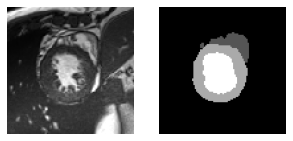

loss score for image :  0.06157998740673065
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


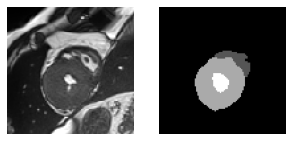

loss score for image :  0.08703318983316422
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


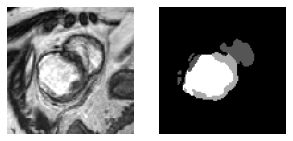

loss score for image :  0.0905551016330719
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


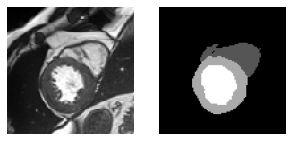

loss score for image :  0.1292477399110794
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


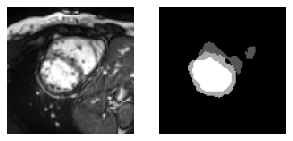

loss score for image :  0.0549631267786026
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


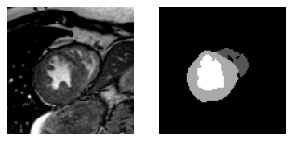

loss score for image :  0.091006800532341
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


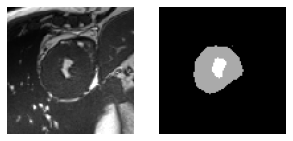

loss score for image :  0.05697108805179596
(96, 96) (2, 96, 96)
(1, 96, 96) (2, 96, 96)


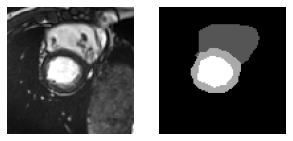

[0.03914152830839157, 0.05449143424630165, 0.051788538694381714, 0.06157998740673065, 0.08703318983316422, 0.0905551016330719, 0.1292477399110794, 0.0549631267786026, 0.091006800532341, 0.05697108805179596]


In [36]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
Learned_model = model
data_path = '/content/drive/MyDrive/data/val'
num_workers = 4
batch_size = 2
loss_list = []
Learned_model.to(device)  #Change
val_set = TrainDataset(data_path)  #Change
test_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
Learned_model.eval()  #Change

for image,mask in test_data_loader:
        #print(image.shape,mask.shape)
        image = image.to(device)
        image = image.unsqueeze(1)
        mask = mask.to(device)
        
        #####PLEASE COMPLETE THE FOLLOWING CODE#####
        #insert the neccessary lines of code to complete the training loop here 
        #(approx 5 lines of code)
        ############################################
        out = Learned_model(image)
        loss = criterion(out,mask.long())
        print('loss score for image : ',loss.item())
        loss_list.append(loss.item())
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        mask_np = mask.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        print(out_np[0].shape,mask_np.shape)
        print(image_np[0].shape,mask_np.shape)
        for i in range(1):
            show_image_mask(image_np[i,0], out_np[i], cmap='gray')
            plt.pause(1)
print(loss_list)
#for iteration, sample in enumerate(test_data_loader):
#   img = sample
#   print(img.shape)
    
#    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
#    plt.pause(1)
#model.eval()

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [33]:
import numpy as np
from torch.autograd import Variable
print(os.getcwd())

/content


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

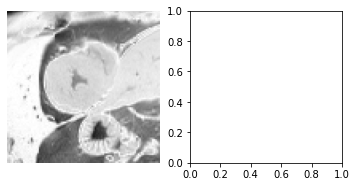

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = '/content/drive/MyDrive/data/test/'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    #print(img.shape)
    x = torch.nn.Conv2d(2, 1, 1) 
    img = img.unsqueeze(0)
    img = x(img)

    img = img.to(device)
    out = model(img)
    #plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    #plt.pause(1)
    plt.subplot(1, 2, 1)
    plt.imshow(img[0,...].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(out.detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()